In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
   This notebook is the implementation
   of CNN-LSTM for time series analysis
   of the sales data
'''

# Ownership
__author__ = ["M. Haseeb Hassan]
__copyright__ = ["Copyrights @ hacceebhassan"]
__license__ = "MIT"
__version__ = "1.0.1"
__maintainer__ = "M. Haseeb Hassan"
__email__ = "hacceebhassan@gmail.com"
__status__ = "Development"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
### ----- Importing Libraries ----- ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import itertools

# Set seeds to make the experiment more reproducible.
import tensorflow
tensorflow.random.set_seed(1)
from numpy.random import seed
seed(1)

In [ ]:
# Dataset
data = pd.read_excel('data/processed_sales_data.xlsx', parse_dates=['date'])
data.head()

company       date      sales
0  Beam Global  2020-07-11  76.377785
1  Beam Global  2020-07-18  81.547145
2  Beam Global  2020-07-25  81.607416
3  Beam Global  2020-08-01  81.607416
4  Beam Global  2020-08-08  81.607416

In [ ]:
# Aggregate the sales by day
daily_sales = data.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = data.groupby(['company', 'date'], as_index=False)['sales'].sum()

In [ ]:
# Daily Sales
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
# Sales Data Company-wise
comp_daily_sales_sc = []
for company in store_daily_sales['company'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['company'] == company)]
    comp_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Company %s' % company)))

layout = go.Layout(title='Company Sales Visualization', xaxis=dict(title='Date'), yaxis=dict(title='Sales'), showlegend=False)
fig = go.Figure(data=comp_daily_sales_sc, layout=layout)
iplot(fig)

### **Data Processing**

In [ ]:
# Transform data into time-series problem

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# Transforming
window = 10
series = series_to_supervised(data.drop('date', axis=1), window=window)
series

company(t-10)  ...  sales(t+1)
10                 Beam Global   ...   45.000000
11                 Beam Global   ...   45.000000
12                 Beam Global   ...   45.000000
13                 Beam Global   ...   45.000000
14                 Beam Global   ...   45.000000
...                         ...  ...         ...
15854  MFS Special Value Trust   ...   45.000000
15855  MFS Special Value Trust   ...   45.000000
15856  MFS Special Value Trust   ...   46.469675
15857  MFS Special Value Trust   ...   46.228592
15858  MFS Special Value Trust   ...   45.000000

[15849 rows x 24 columns]

In [ ]:
# Drop rows with different company values than the shifted columns
last_company = 'company(t-%d)' % window
series = series[(series['company(t)'] == series[last_company])]
series

In [ ]:
# Remove unwanted columns
lag = 1
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['company']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['company']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['company(t)'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
series

sales(t-10)  sales(t-9)  sales(t-8)  ...  sales(t-1)   sales(t)  sales(t+1)
10       76.377785   81.547145   81.607416  ...   45.000000  45.000000   45.000000
11       81.547145   81.607416   81.607416  ...   45.000000  45.000000   45.000000
12       81.607416   81.607416   81.607416  ...   45.000000  45.000000   45.000000
13       81.607416   81.607416   81.607416  ...   45.000000  45.000000   45.000000
14       81.607416   81.607416   81.607416  ...   45.000000  45.000000   45.000000
...            ...         ...         ...  ...         ...        ...         ...
15854    45.000000   45.000000   45.000000  ...   45.000000  45.000000   45.000000
15855    45.000000   45.000000   45.000000  ...   45.000000  45.000000   45.000000
15856    45.000000   45.000000   45.000000  ...   45.000000  45.000000   46.469675
15857    45.000000   45.000000   45.000000  ...   45.000000  46.469675   46.228592
15858    45.000000   45.000000   45.000000  ...   46.469675  46.228592   45.000000

[9759 rows x 12 columns]

In [ ]:
# Label
labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.01, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (9661, 11)
Validation set shape (98, 11)


sales(t-10)  sales(t-9)  sales(t-8)  ...  sales(t-2)  sales(t-1)    sales(t)
7893     48.894406   86.939043   89.424045  ...   48.894406   64.309763   73.039723
19       45.000000   45.000000   45.000000  ...   45.000000   45.000000   45.000000
15778    48.115525   48.115525   48.115525  ...   49.005675   47.225375   48.115525
544     626.221545  624.515425  619.559329  ...  625.725472  625.628112  624.487607
1788     45.000000   45.000000   45.000000  ...   45.000000   45.000000   45.000000

[5 rows x 11 columns]

### **MLP for Time Series Forecasting**

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape [samples, timesteps].

In [ ]:
# Initializing Parameters

epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
# Model

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting Model 

mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
302/302 - 1s - loss: 2240611.0000 - val_loss: 39809.1055
Epoch 2/40
302/302 - 0s - loss: 1935983.5000 - val_loss: 63985.6797
Epoch 3/40
302/302 - 0s - loss: 1726279.2500 - val_loss: 49140.0625
Epoch 4/40
302/302 - 0s - loss: 1729507.5000 - val_loss: 46987.8633
Epoch 5/40
302/302 - 0s - loss: 1706472.6250 - val_loss: 48430.7773
Epoch 6/40
302/302 - 0s - loss: 1633551.5000 - val_loss: 49981.6367
Epoch 7/40
302/302 - 0s - loss: 1576779.1250 - val_loss: 91492.9062
Epoch 8/40
302/302 - 0s - loss: 1510459.0000 - val_loss: 50764.4648
Epoch 9/40
302/302 - 0s - loss: 1620215.0000 - val_loss: 43433.4336
Epoch 10/40
302/302 - 0s - loss: 1494687.8750 - val_loss: 50419.7617
Epoch 11/40
302/302 - 0s - loss: 1512604.3750 - val_loss: 50120.8789
Epoch 12/40
302/302 - 0s - loss: 1521868.6250 - val_loss: 121975.8750
Epoch 13/40
302/302 - 0s - loss: 1518873.0000 - val_loss: 39596.9727
Epoch 14/40
302/302 - 0s - loss: 1462115.6250 - val_loss: 37886.9883
Epoch 15/40
302/302 - 0s - loss: 1424327.8

### **CNN for Time Series Forecasting**


* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape [samples, timesteps, features].

In [ ]:
# Reshape from [samples, timesteps] into [samples, timesteps, features]
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (9661, 11, 1)
Validation set shape (98, 11, 1)


In [ ]:
# Model

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting Model

cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
302/302 - 1s - loss: 2783006.5000 - val_loss: 30500.2852
Epoch 2/40
302/302 - 0s - loss: 2208380.5000 - val_loss: 43823.9727
Epoch 3/40
302/302 - 0s - loss: 1899821.1250 - val_loss: 41620.1445
Epoch 4/40
302/302 - 0s - loss: 1795310.6250 - val_loss: 42508.1641
Epoch 5/40
302/302 - 0s - loss: 1823112.6250 - val_loss: 48261.8008
Epoch 6/40
302/302 - 0s - loss: 1694333.6250 - val_loss: 61942.4141
Epoch 7/40
302/302 - 0s - loss: 1596301.5000 - val_loss: 96614.7734
Epoch 8/40
302/302 - 0s - loss: 1527498.8750 - val_loss: 64197.7109
Epoch 9/40
302/302 - 0s - loss: 1677824.3750 - val_loss: 67228.2812
Epoch 10/40
302/302 - 0s - loss: 1507437.1250 - val_loss: 67369.4609
Epoch 11/40
302/302 - 0s - loss: 1536942.6250 - val_loss: 73440.8438
Epoch 12/40
302/302 - 0s - loss: 1516682.2500 - val_loss: 142922.9844
Epoch 13/40
302/302 - 0s - loss: 1541413.5000 - val_loss: 71836.9297
Epoch 14/40
302/302 - 0s - loss: 1482333.3750 - val_loss: 55341.0391
Epoch 15/40
302/302 - 0s - loss: 1447060.2

### **LSTM for Time Series Forecasting**


* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape [samples, timesteps, features].

In [ ]:
# Model

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting Model

lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
302/302 - 3s - loss: 4043756.0000 - val_loss: 65236.6016
Epoch 2/40
302/302 - 1s - loss: 2451536.7500 - val_loss: 43431.8320
Epoch 3/40
302/302 - 2s - loss: 2986563.7500 - val_loss: 18977.8516
Epoch 4/40
302/302 - 2s - loss: 2488449.2500 - val_loss: 50337.0156
Epoch 5/40
302/302 - 2s - loss: 2754457.5000 - val_loss: 53157.8516
Epoch 6/40
302/302 - 2s - loss: 2740311.2500 - val_loss: 143633.6562
Epoch 7/40
302/302 - 2s - loss: 2709398.2500 - val_loss: 70982.0234
Epoch 8/40
302/302 - 2s - loss: 2227119.5000 - val_loss: 38889.3672
Epoch 9/40
302/302 - 2s - loss: 2174193.7500 - val_loss: 67327.6094
Epoch 10/40
302/302 - 2s - loss: 2561262.2500 - val_loss: 114128.9375
Epoch 11/40
302/302 - 2s - loss: 3233701.5000 - val_loss: 128768.8047
Epoch 12/40
302/302 - 2s - loss: 4265306.0000 - val_loss: 251062.3125
Epoch 13/40
302/302 - 2s - loss: 2608198.5000 - val_loss: 81269.7109
Epoch 14/40
302/302 - 2s - loss: 2506578.5000 - val_loss: 44371.3828
Epoch 15/40
302/302 - 2s - loss: 241638

### **CNN-LSTM for Time Series Forecasting**

* Input shape [samples, subsequences, timesteps, features]

In [ ]:
# Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]

subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (9661, 1, 11, 1)
Validation set shape (98, 1, 11, 1)


In [ ]:
# Model

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
# Fitting Model
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
302/302 - 2s - loss: 2925065.0000 - val_loss: 30452.3281
Epoch 2/40
302/302 - 1s - loss: 2441320.0000 - val_loss: 41185.2852
Epoch 3/40
302/302 - 1s - loss: 2173336.0000 - val_loss: 38343.0664
Epoch 4/40
302/302 - 1s - loss: 2095277.3750 - val_loss: 52336.1133
Epoch 5/40
302/302 - 1s - loss: 2149292.2500 - val_loss: 47771.0625
Epoch 6/40
302/302 - 1s - loss: 2039518.6250 - val_loss: 54411.3125
Epoch 7/40
302/302 - 1s - loss: 1925569.6250 - val_loss: 87620.1094
Epoch 8/40
302/302 - 1s - loss: 1886665.0000 - val_loss: 56683.3555
Epoch 9/40
302/302 - 1s - loss: 2018405.6250 - val_loss: 74137.0938
Epoch 10/40
302/302 - 1s - loss: 1907648.8750 - val_loss: 85782.9609
Epoch 11/40
302/302 - 1s - loss: 1912113.6250 - val_loss: 88287.5781
Epoch 12/40
302/302 - 1s - loss: 1916096.1250 - val_loss: 155808.9688
Epoch 13/40
302/302 - 1s - loss: 1909517.7500 - val_loss: 70233.4688
Epoch 14/40
302/302 - 1s - loss: 1866578.2500 - val_loss: 72820.7344
Epoch 15/40
302/302 - 1s - loss: 1811933.8

### **Models Comparison**

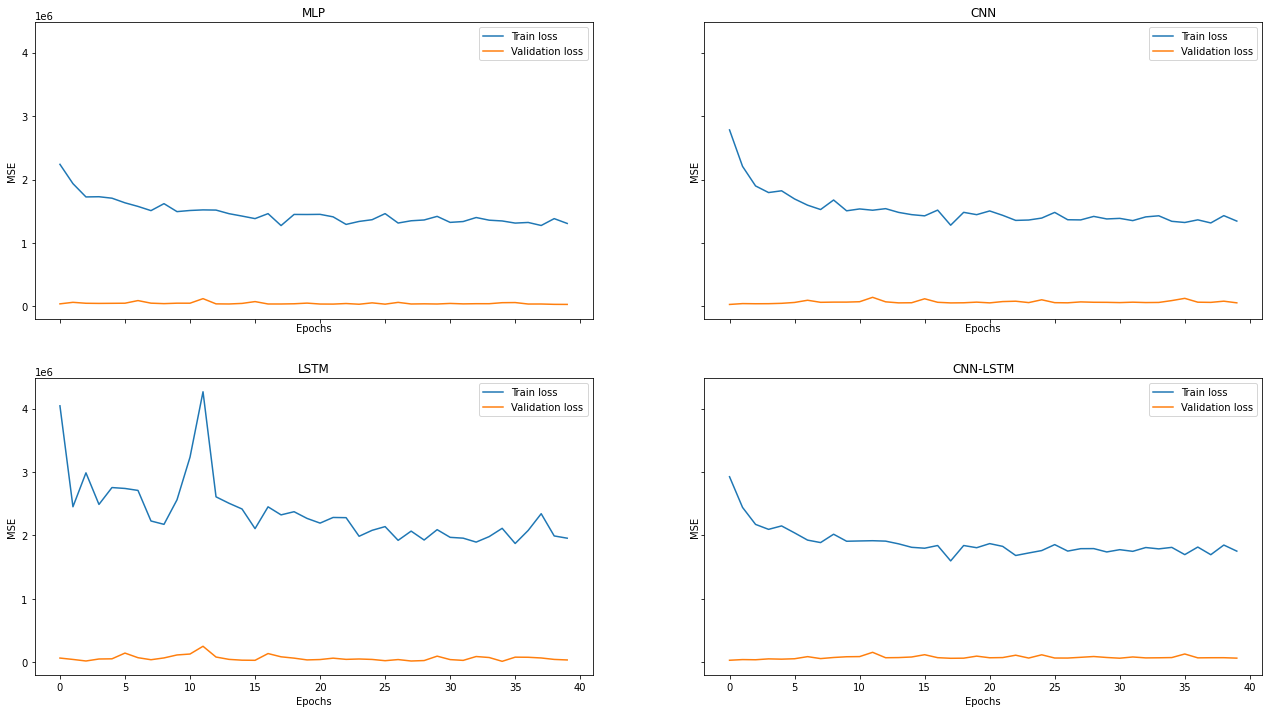

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
# MLP on train and validation
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('----- MLP -----')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))
print('===============')

# CNN on train and validation¶
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('----- CNN -----')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))
print('===============')

# LSTM on train and validation
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('----- LSTM -----')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))
print('===============')

# CNN-LSTM on train and validation
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('----- CNN-LSTM -----')
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))
print('===============')

----- MLP -----
Train rmse: 1086.6886793161989
Validation rmse: 176.25258780564195
----- CNN -----
Train rmse: 1107.967658147537
Validation rmse: 236.48680696770833
----- LSTM -----
Train rmse: 1358.3510608473296
Validation rmse: 236.48680696770833
----- CNN-LSTM -----
Train rmse: 1298.8847516000915
Validation rmse: 252.82149883288415
